# Setup

In [4]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.dates as pltdate
import seaborn as sns
import datetime
import time
import numpy as np
import pandas as pd
from dateutil import parser
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import lifelines as sa
from lifelines.utils import concordance_index, k_fold_cross_validation
import patsy as pt
import math

# Set default styles for plotting via pandas, seaborn and matplotlib
pd.set_option('display.mpl_style', 'default')
pd.set_option('display.notebook_repr_html', True)
sns.set(style='darkgrid')
#cmap_clrbld = ['#777777','#E69F00','#56B4E9','#D3C511'
#               ,'#009E73','#8D42F0','#0072B2','#D55E00','#CC79A7']
#plt.rcParams['axes.color_cycle'] = cmap_clrbld
plt.rcParams['figure.figsize'] = 15, 6

np.random.seed(0)

C:\Users\georg\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:2881: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
def makeunixtime(val):
    try:
        return int(time.mktime(parser.parse(val).timetuple()))
    except (OverflowError, AttributeError, ValueError):
        return None


def unixtimetostr(val):
        return datetime.datetime.fromtimestamp(int(val)).strftime('%Y-%m-%d %H:%M:%S')

# Prepare data

In [6]:
sessionDF = pd.read_pickle('../../data/timedSessionDF.pkl')

In [6]:
trainPeriod = ["2015-02-01", "2016-02-01"]
testPeriod = ["2016-02-01", "2016-04-01"]

In [7]:
trainPeriodFilter = (sessionDF['startUserTime'] >= makeunixtime(trainPeriod[0])) & (sessionDF['startUserTime'] < makeunixtime(trainPeriod[1]))
predictionPeriodFilter = (sessionDF['startUserTime'] >= makeunixtime(testPeriod[0])) & (sessionDF['startUserTime'] < makeunixtime(testPeriod[1]))

uniqueCustomerId = sessionDF.customerId.unique()
customerIdEnc = preprocessing.LabelEncoder().fit(uniqueCustomerId)

In [8]:
sessionTrainingPeriodDF = sessionDF[(sessionDF['startUserTime'] > makeunixtime(trainPeriod[0])) & (sessionDF['startUserTime'] < makeunixtime(trainPeriod[1]))]
sessionPredictionPeriodDF = sessionDF[(sessionDF['startUserTime'] > makeunixtime(testPeriod[0])) & (sessionDF['startUserTime'] < makeunixtime(testPeriod[1]))]

customerTrainingPeriodIdx = customerIdEnc.transform(np.squeeze(np.asarray(sessionTrainingPeriodDF.as_matrix(columns=['customerId']))))

bucketSize = 3600*24
buckets = np.asarray(range(makeunixtime(trainPeriod[0])+bucketSize//2,makeunixtime(trainPeriod[1])+bucketSize//2,bucketSize))

### Clean device column

In [9]:
sessionDF.loc[sessionDF.device.str.match(".*[dDtT]esktop.*") == True,"device"] = "desktop"
sessionDF.loc[sessionDF.device.str.match("[mM]obile") == True,"device"] = "mobile"

### Append return time

In [16]:
returnTimeDF = pd.read_pickle('../../data/mergedSessionDF.pkl')

### Create observation window

Using all observations from 2015.

In [24]:
trainDF = pd.read_pickle('../../data/trainFebToFebCensoredMergedDF.pkl')
testDF = pd.read_pickle('../../data/testFebToFebCensoredMergedDF.pkl')

In [25]:
# trainDF = returnTimeDF[(returnTimeDF['startUserTime'] >= makeunixtime(trainPeriod[0])) & (returnTimeDF['startUserTime'] < makeunixtime(trainPeriod[1]))]
trainDF['startTime0'] = trainDF['startTime'] - makeunixtime(trainPeriod[0])
testDF['startTime0'] = testDF['startTime'] - makeunixtime(trainPeriod[0])

#### Visualising return time

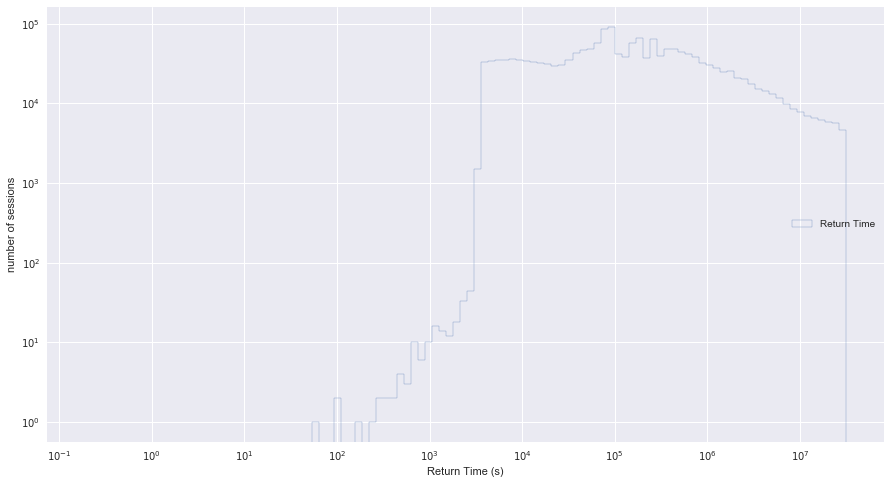

In [26]:
logReturnTimeBucketSize = 10 # 5 seconds
logMaxReturnTime = int(((trainDF.returnTime.max()//logReturnTimeBucketSize) + 1) * logReturnTimeBucketSize)
logReturnTimeBuckets = np.logspace(0, math.log(logMaxReturnTime+logReturnTimeBucketSize, logReturnTimeBucketSize), num=100, endpoint=True, base=logReturnTimeBucketSize) - 1

fig, ax = plt.subplots(figsize=(15, 8))
#ax.set_color_cycle(['c', 'm', 'y', 'k'])
#ax.set_axis_bgcolor((1, 1, 1))

ax.hist(trainDF[trainDF.returnTime.notnull()].returnTime, bins=logReturnTimeBuckets, histtype='step', cumulative=False, label='Return Time')

ax.grid(True)
ax.legend(loc='right')
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
ax.set_xlabel('Return Time (s)')
ax.set_ylabel('number of sessions')


Weird jumps: check for device types

In [27]:
def plotReturnTime(df):
    logReturnTimeBucketSize = 10 # seconds
    logMaxReturnTime = int(((df.returnTime.max()//logReturnTimeBucketSize) + 1) * logReturnTimeBucketSize)
    logReturnTimeBuckets = np.logspace(0, math.log(logMaxReturnTime+logReturnTimeBucketSize, logReturnTimeBucketSize), num=100, endpoint=True, base=logReturnTimeBucketSize) - 1

    fig, ax = plt.subplots(figsize=(15, 8))
    ax.set_color_cycle(['c', 'm', 'y', 'k'])
    ax.set_axis_bgcolor((1, 1, 1))

    for i, group in df.groupby('device'):
        ax.hist(group[group.returnTime.notnull()].returnTime, bins=logReturnTimeBuckets, histtype='step', cumulative=False, label=str(i), normed=True)

    ax.grid(True)
    ax.legend(loc='right')
    plt.gca().set_xscale("log")
    plt.gca().set_yscale("log")
    ax.set_xlabel('Return Time (s)')
    ax.set_ylabel('number of sessions (normalised)')


/homes/glg113/.local/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/homes/glg113/.local/lib/python3.5/site-packages/ipykernel/__main__.py:8: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


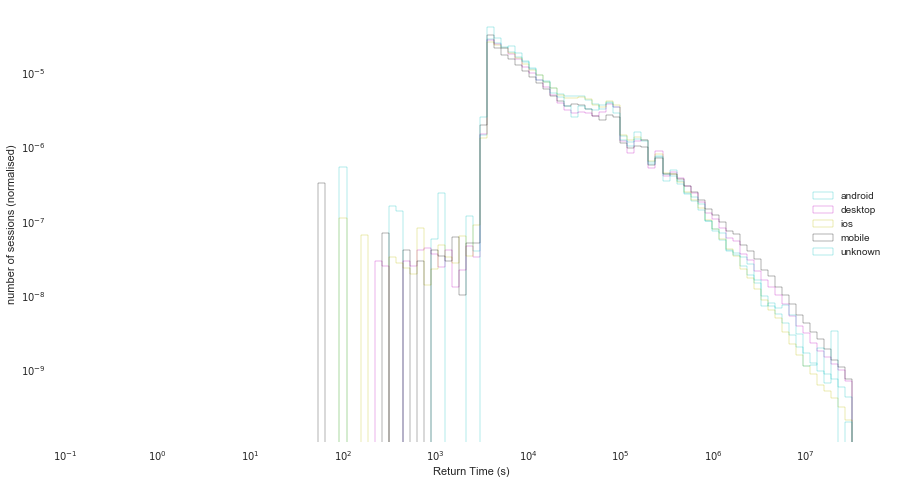

In [28]:
plotReturnTime(trainDF)

Add right censoring

In [29]:
# trainDF['observed'] = (trainDF['startUserTime'] + trainDF['returnTime']) < makeunixtime(trainPeriod[1])
# #testDF['observed'] = (testDF['startUserTime'] + testDF['returnTime']) < makeunixtime(testPeriod[1])
# trainDF['returnTime'] = pd.DataFrame([trainDF['returnTime'], makeunixtime(trainPeriod[1]) - trainDF['startUserTime']]).min()

### Bucket days

In [30]:
bucketSize = 3600*24
buckets = np.asarray(range(makeunixtime(trainPeriod[0]), makeunixtime(trainPeriod[1])+bucketSize, bucketSize))

In [32]:
trainDF['day'] = pd.cut(trainDF['startUserTime'], buckets, labels=range(len(buckets)-1))

### Visualise days

In [33]:
gp = trainDF.groupby(['device','day']).size().unstack()

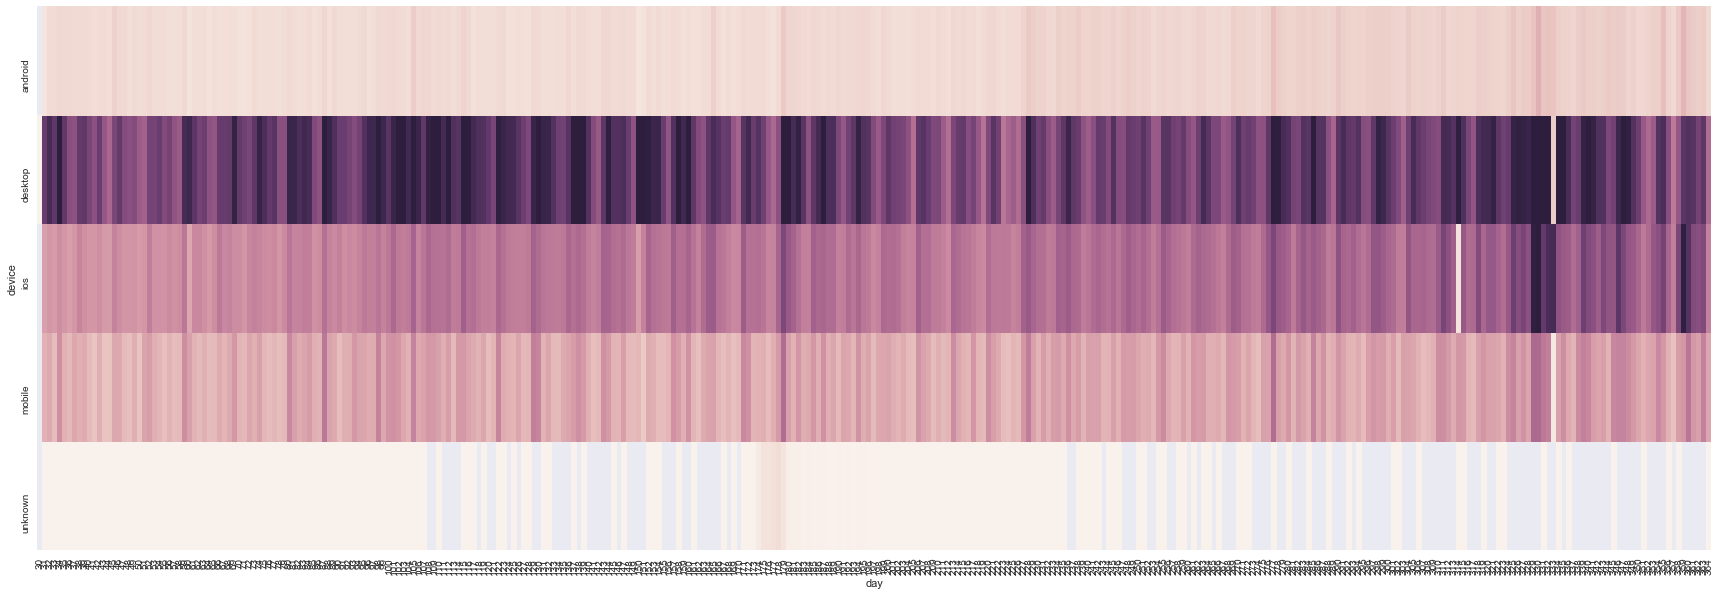

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=[30,10], squeeze=False)
ax = sns.heatmap(gp, mask=pd.isnull(gp), ax=axes[0,0],robust=True, cbar=False)

### Session length

In [35]:
lengthBucketSize = 60 # 1 minute
maxSessionLength = int(((trainDF.sessionLength.max()//lengthBucketSize) + 1) * lengthBucketSize)
sessionLengthBuckets = np.asarray(range(0, maxSessionLength + lengthBucketSize, lengthBucketSize))

In [36]:
trainDF['sessionLengthBucket'] = pd.cut(trainDF['sessionLength'], sessionLengthBuckets, labels=range(len(sessionLengthBuckets)-1), include_lowest=True)

#### linear view

In [37]:
gpSessionLength = trainDF.groupby(['device','sessionLengthBucket']).size().unstack()

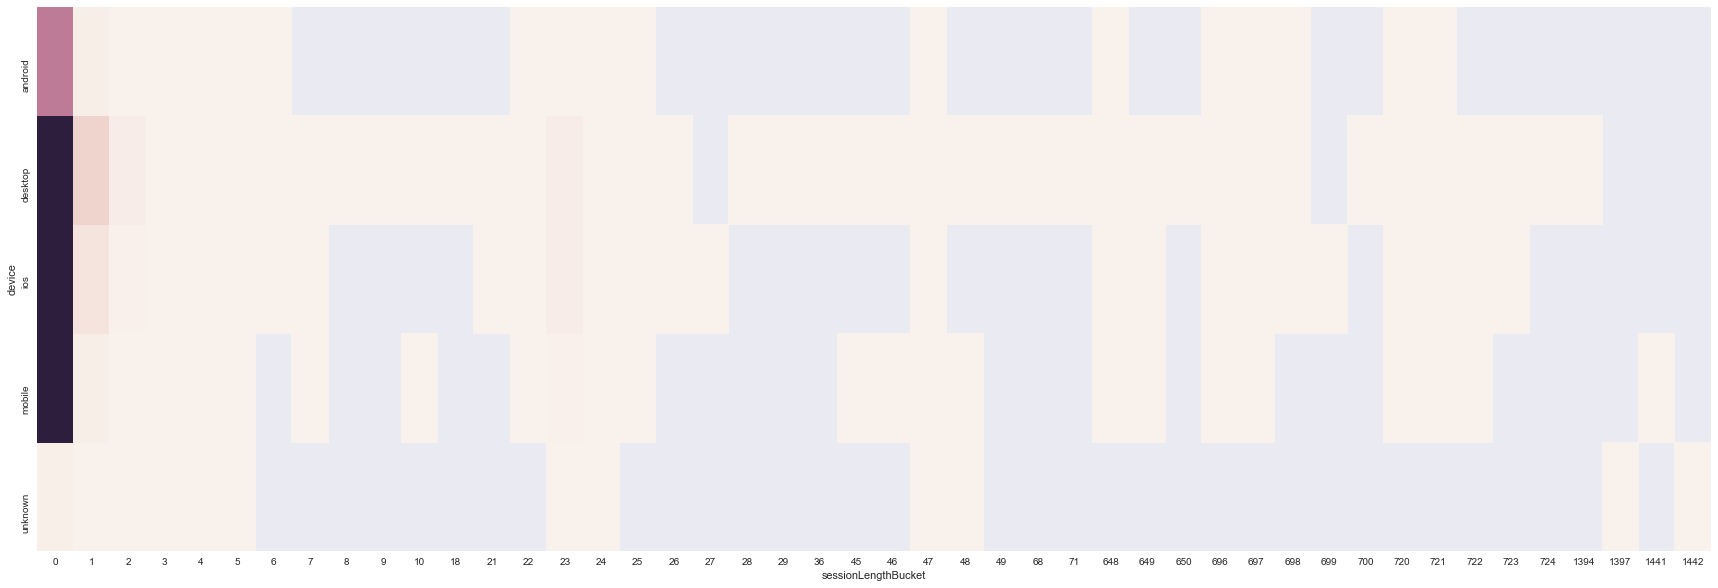

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=[30,10], squeeze=False)
ax = sns.heatmap(gpSessionLength, mask=pd.isnull(gpSessionLength), ax=axes[0,0],robust=True, cbar=False)

In [39]:
logLengthBucketSize = 5 # 5 seconds
logMaxSessionLength = int(((trainDF.sessionLength.max()//logLengthBucketSize) + 1) * logLengthBucketSize)
#logSessionLengthBuckets = np.asarray(range(0, maxSessionLength + lengthBucketSize, lengthBucketSize))
logSessionLengthBuckets = np.logspace(0, math.log(logMaxSessionLength+logLengthBucketSize, logLengthBucketSize), num=20, endpoint=True, base=logLengthBucketSize) - 1

In [40]:
trainDF['logSessionLengthBucket'] = pd.cut(trainDF['sessionLength'], logSessionLengthBuckets, labels=range(len(logSessionLengthBuckets)-1), include_lowest=True)

In [41]:
gpLogSessionLength = trainDF.groupby(['device','logSessionLengthBucket']).size().unstack()

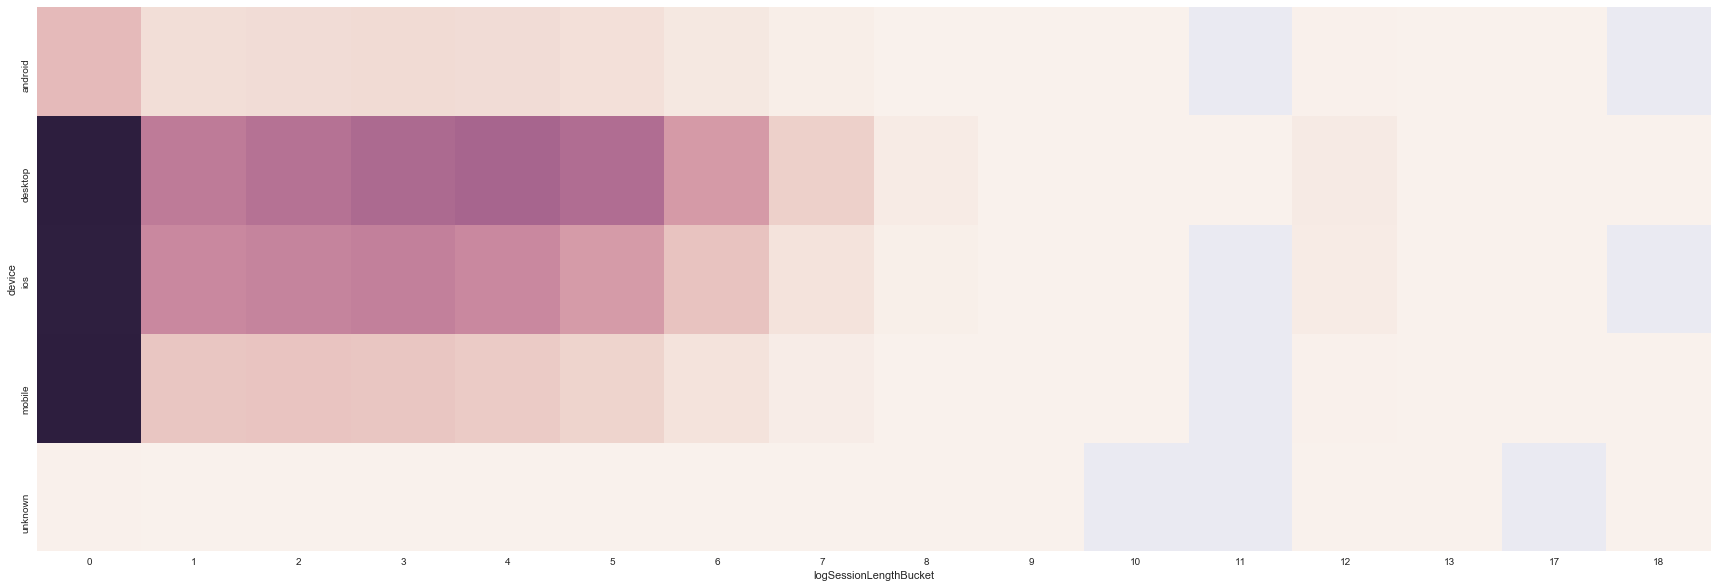

In [42]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=[30,10], squeeze=False)
ax = sns.heatmap(gpLogSessionLength, mask=pd.isnull(gpLogSessionLength), ax=axes[0,0],robust=True, cbar=False)

In [43]:
def pltSessionLen(df): logLengthBucketSizePlt = 10 # seconds logMaxSessionLengthPlt = int(((df.sessionLength.max()//logLengthBucketSizePlt) + 1) * logLengthBucketSizePlt) logSessionLengthBucketsPlt = np.logspace(0, math.log(logMaxSessionLengthPlt+logLengthBucketSizePlt, logLengthBucketSizePlt), num=100, endpoint=True, base=logLengthBucketSizePlt) - 1  bins=logSessionLengthBucketsPlt  #cleanDF.groupby('device').apply(lambda x: x.sessionLength.sort_values().plot(logy=True))  fig, ax = plt.subplots(figsize=(15, 8)) ax.set_color_cycle(['c', 'm', 'y', 'k']) ax.set_axis_bgcolor((1, 1, 1))  for i, group in df.groupby('device'): ax.hist(group.sessionLength, bins=logSessionLengthBucketsPlt, histtype='step', cumulative=False, label=str(i)) #    group.sessionLength.sort_values().plot(logy=True,title=str(i)) # plot the cumulative histogram #ax.hist(sessionsLengthsSorted, bins=bins, histtype='step', #                           cumulative=False, label='Empirical')  # tidy up the figure ax.grid(True) ax.legend(loc='right') plt.gca().set_xscale("log") plt.gca().set_yscale("log") ax.set_xlabel('Session length (s)') ax.set_ylabel('number of sessions') 

In [45]:
pltSessionLen(trainDF)

In [124]:
trainDF[(trainDF.device=='desktop') & (trainDF.sessionLength>600)].sessionLength.mode()

0    1438.9833
dtype: float64

#### Conclusions
- High ration of <.75s sessions (**bucket 0**)
- High ratio of bounces: <2.1 sec sessions (**bucket 1**)
- Increase in sessions longer than 15 min: **bucket 11**

Need to eliminate sessions below 3s and truncate session length to 25min

### Eliminate bouces

In [46]:
cleanDF = trainDF[(trainDF['sessionLength'] >= 3)]
cleanDF.sessionLength = cleanDF.sessionLength.clip(0,25*60)

/homes/glg113/.local/lib/python3.5/site-packages/pandas/core/generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


#### Need to re-evaluate return time

In [47]:
sortedSessionDF = sessionDF.sort_values('startTime')

def addReturnTime(x):
    x = x.sort_values('startTime')
    x['returnTime'] = x['startTime'].diff().shift(-1)
    return x

cleanReturnTimeDF = sortedSessionDF[sortedSessionDF['sessionLength'] >= 3].groupby('customerId').apply(addReturnTime)

KeyboardInterrupt: 

In [134]:
cleanDF = cleanReturnTimeDF[(cleanReturnTimeDF['startUserTime'] >= makeunixtime(trainPeriod[0])) & (cleanReturnTimeDF['startUserTime'] < makeunixtime(trainPeriod[1]))]

/homes/glg113/.local/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/homes/glg113/.local/lib/python3.5/site-packages/ipykernel/__main__.py:12: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


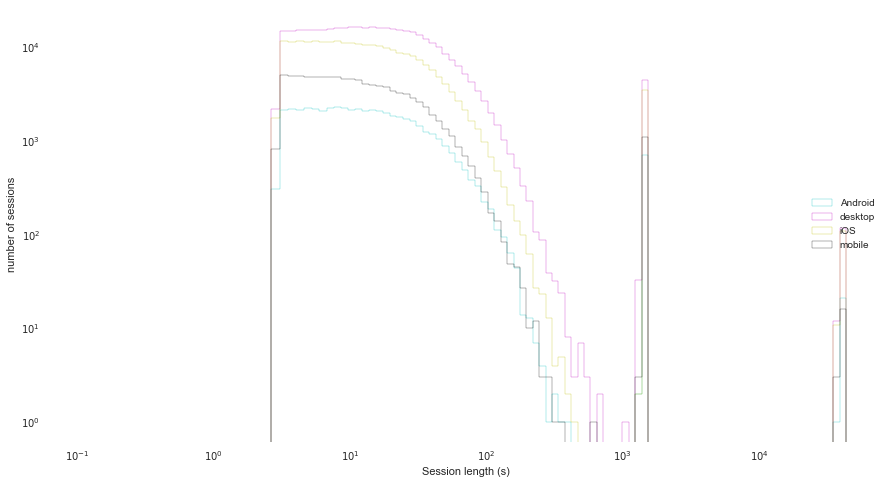

In [139]:
pltSessionLen(cleanDF)

/homes/glg113/.local/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/homes/glg113/.local/lib/python3.5/site-packages/ipykernel/__main__.py:8: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


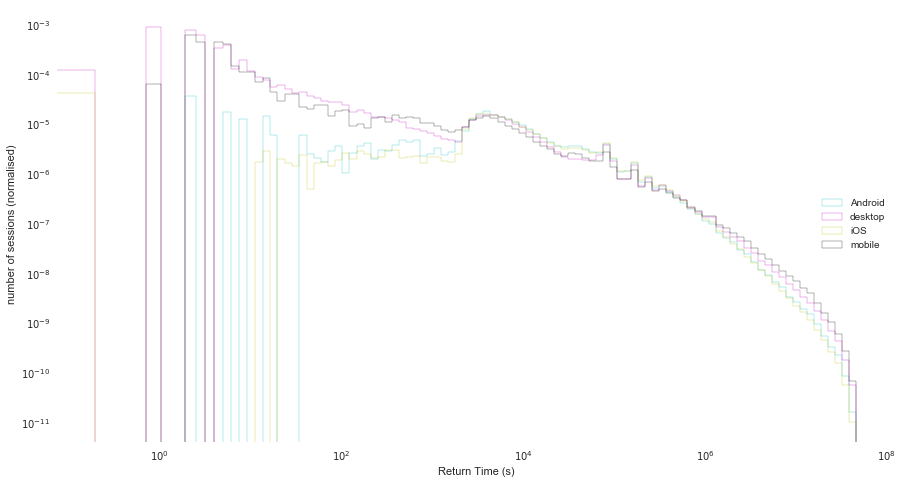

In [144]:
plotReturnTime(cleanDF)

In [147]:
cleanDF.groupby(['device']).sessionLength.apply(lambda x: x.median())

device
Android    12.583333
desktop    14.550000
iOS        11.966666
mobile     10.816667
Name: sessionLength, dtype: float64

In [150]:
cleanDF.groupby(['device']).returnTime.apply(lambda x: x.median())

device
Android    155750.0
desktop    246606.0
iOS        163396.0
mobile     342908.0
Name: returnTime, dtype: float64

In [151]:
cleanDF[['numberdivisions', 'avgPrice', 'viewonly', 'changeThumbnail', 'imageZoom', 'watchVideo', 'view360', 'sizeGuide']].mean()

numberdivisions     1.431081
avgPrice           30.548952
viewonly           17.862417
changeThumbnail    13.008210
imageZoom           1.214689
watchVideo          0.727749
view360             0.025199
sizeGuide           0.000000
dtype: float64

### No observations for sizeGuide
Remove field

In [152]:
del cleanDF['sizeGuide']

### Censoring

In [154]:
predDF = cleanDF.copy()

In [155]:
predDF['observed'] = (predDF['startUserTime'] + predDF['returnTime']) < makeunixtime(trainPeriod[1])
predDF['returnTime'] = pd.DataFrame([predDF['returnTime'], makeunixtime(trainPeriod[1]) - predDF['startUserTime']]).min()

In [159]:
predDF = predDF.reset_index(drop=True) # flatten

In [160]:
predDF

,customerId,sessionId,startTime,startUserTime,sessionLength,numberdivisions,avgPrice,viewonly,changeThumbnail,imageZoom,watchVideo,view360,device,returnTime,observed
0,4600,1257495808-1341698085-1.428265218E9,1428265218,1.428265e+09,25.333334,1,21.900000,16,0,0,0,0,iOS,18548596.0,True
1,4600,5371143799284085389-3809498348446746724-1.4468...,1446813814,1.446814e+09,23.250000,1,20.372500,4,6,0,1,0,desktop,1828703.0,True
2,4600,5371143799284085389-3809498348446746724-1.4486...,1448642517,1.448643e+09,32.733334,2,78.333336,10,0,0,0,0,desktop,15030.0,True
3,4600,5371143799284085389-3809498348446746724-1.4486...,1448657547,1.448658e+09,59.233334,1,32.380478,50,114,18,0,0,desktop,40531.0,True
4,4600,5371143799284085389-3809498348446746724-1.4486...,1448698078,1.448698e+09,27.083334,1,24.248236,35,61,6,0,0,desktop,27119.0,True
5,4600,5371143799284085389-3809498348446746724-1.4487...,1448725197,1.448725e+09,40.750000,1,23.924000,28,45,4,2,0,desktop,102099.0,True
6,4600,5371143799284085389-3809498348446746724-1.4488...,1448827296,1.448827e+09,52.200000,2,26.824000,26,23,5,1,0,desktop,6248.0,True
7,4600,5371143799284085389-3809498348446746724-1.4488...,1448833544,1.448834e+09,5.733333,1,17.500000,4,6,0,0,0,desktop,2772856.0,False
8,4800,5254901231698233801-2901597573009043271-1.4373...,1437319952,1.437324e+09,4.683333,1,22.750000,6,8,0,0,0,mobile,154360.0,True
9,4800,5254901231698233801-2901597573009043271-1.4374...,1437474312,1.437478e+09,5.183333,1,39.000000,5,8,0,1,0,mobile,14128488.0,False


### Customers without device

In [208]:
predDF.device.isnull().sum()

4424

In [209]:
noDeviceCustomers = predDF[predDF.device.isnull()]['customerId'].unique()

In [212]:
predDevicesDF = predDF[~predDF.customerId.isin(noDeviceCustomers)]

# Apply CPH Model
Whole set takes too long to train. Sample customers representing each device type.

In [214]:
customers = predDevicesDF.groupby(['device']).apply(lambda x: x.customerId.sample(100)).values

In [215]:
samplePredDF = predDevicesDF[predDevicesDF.customerId.isin(customers)]

In [228]:
modelspec = 'device - 1'

dft = pt.dmatrix(modelspec, samplePredDF, return_type='dataframe')
design_info = dft.design_info
dft = dft.join(samplePredDF[['numberdivisions','viewonly','sessionLength','returnTime','observed']])

In [229]:
dft.head().T

,3568,3569,3570,3571,3572
device[Android],0,0,0,0,0
device[desktop],0,0,0,0,0
device[iOS],1,1,1,1,1
device[mobile],0,0,0,0,0
numberdivisions,2,2,1,1,1
viewonly,7,5,33,23,27
sessionLength,3.1,6.83333,36.15,33.1333,6.46667
returnTime,838690,2.01103e+06,171493,436883,3.70643e+06
observed,True,True,True,True,True


In [223]:
cx = sa.CoxPHFitter(normalize=False)
cx.fit(df=dft, duration_col='returnTime', event_col='observed',show_progress=False, include_likelihood=True)

<lifelines.CoxPHFitter: fitted with 22588 observations, 391 censored>

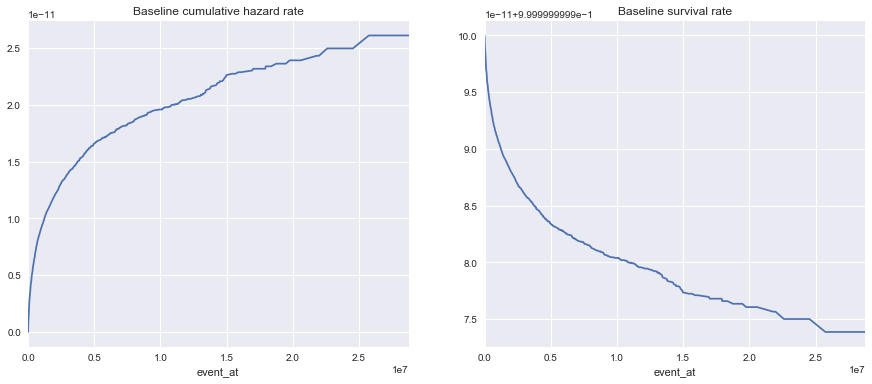

In [224]:
fig, axes = plt.subplots(nrows=1, ncols=2, squeeze=False, sharex=True)
cx.baseline_cumulative_hazard_.plot(ax=axes[0,0], legend=False
                ,title='Baseline cumulative hazard rate')
cx.baseline_survival_.plot(ax=axes[0,1], legend=False
                ,title='Baseline survival rate')

In [230]:
cx.baseline_survival_

,baseline hazard
event_at,
0.0,1.0
4.0,1.0
5.0,1.0
9.0,1.0
27.0,1.0
48.0,1.0
58.0,1.0
72.0,1.0
82.0,1.0


In [225]:
cx.summary

,coef,exp(coef),se(coef),z,p,lower 0.95,upper 0.95
device[Android],2.626337e+01,2.547044e+11,180494.106010,0.000146,9.998839e-01,-353813.464588,353865.991327
device[desktop],2.598397e+01,1.926178e+11,180494.106010,0.000144,9.998851e-01,-353813.743984,353865.711931
device[iOS],2.622792e+01,2.458338e+11,180494.106010,0.000145,9.998841e-01,-353813.500036,353865.955879
device[mobile],2.591285e+01,1.793946e+11,180494.106010,0.000144,9.998855e-01,-353813.815104,353865.640811
numberdivisions,1.027878e-01,1.108256e+00,0.011145,9.222804,2.894296e-20,0.080939,0.124636
viewonly,8.536734e-04,1.000854e+00,0.000117,7.269286,3.613914e-13,0.000623,0.001084
sessionLength,-3.608873e-07,9.999996e-01,0.000015,-0.023429,9.813078e-01,-0.000031,0.000030


# Next Steps

Test predictions

In [237]:
cx.predict_expectation(dft.head(3))

,0
3568,319685.181817
3569,321032.950354
3570,390902.486729


In [238]:
predictDF = cleanReturnTimeDF[(cleanReturnTimeDF['startUserTime'] >= makeunixtime(testPeriod[0])) & (cleanReturnTimeDF['startUserTime'] < makeunixtime(testPeriod[1]))]

In [242]:
predictDF = predictDF.reset_index(drop=True) # flatten

In [246]:
predDft = pt.dmatrix(modelspec, predictDF, return_type='dataframe')
predDft = predDft.join(predictDF[['numberdivisions','viewonly','sessionLength','returnTime']])

In [260]:
cx.predict_expectation(dft.head(10))

,0
3568,319685.181817
3569,321032.950354
3570,390902.486729
3571,399431.141891
3572,395985.216884
3573,416196.584521
3574,412601.674667
3575,409927.002445
3576,393433.271806
3577,413504.778135


In [252]:
predDft.head(10).returnTime

0      36488.0
1     423584.0
2      81759.0
3    5756563.0
4    3697830.0
5    6251483.0
6    1783032.0
7     109509.0
8     240680.0
9     696046.0
Name: returnTime, dtype: float64

In [1]:
cx.predict_expectation(predDft.head(10)).subtract(predDft.head(10).returnTime)

NameError: name 'cx' is not defined